In [5]:
import pcpm
import dico_toolbox as dtb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import colorado as cld
import deep_folding.brainvisa.utils.convert_volume_to_bucket
from soma import aims
import json
import os

In [2]:
pcpm.distance.set_DEFAULT_DIST_FUNCTION_NAME("coarse_PCA")
pcpm.distance.get_DEFAULT_DIST_FUNCTION_NAME()

'coarse_PCA'

In [3]:
# Release3
dir_Release3 = '/neurospin/grip/external_databases/dHCP_CR_JD_2018/Projects/denis/release3_scripts/subjects_file_v4.json'
with open(dir_Release3) as f:
    subjects_R3 = json.load(f)

subjects_R3 = list(subjects_R3.keys())

# get the session ids of R3
dir_sessions = '/neurospin/grip/external_databases/dHCP_CR_JD_2018/Projects/denis/release3_scripts/subjects_file_v4.json'
with open(dir_sessions) as f:
    dict_sessions = json.load(f)
sessions = [value['session_id'] for _, value in dict_sessions.items()]

# get dHCP info
dir_info_dHCP = '/home/jl274628/Documents/info_dHCP.tsv'
info_dHCP = pd.read_csv(dir_info_dHCP, usecols=['participant_id', 'birth_age', 'session_id'], sep='\t')
# filter over subjects
info_dHCP.drop(info_dHCP[~(info_dHCP['participant_id'].isin(subjects_R3))].index, inplace = True)
#info_dHCP.drop(info_dHCP[(info_dHCP['scan_number']!=1)].index, inplace = True) # not always scan 1
# filter over sessions
info_dHCP.drop(info_dHCP[~(info_dHCP['session_id'].isin(sessions))].index, inplace = True)
info_dHCP.reset_index(drop=True, inplace=True)

In [4]:
# get descriptor list : dim9 or birth age
# dim9
#embeddings = pd.read_csv('/neurospin/dico/jlaval/Runs/01_deep_supervised/Program/Output/2023-06-16/11-54-27/STs_dHCP_374_subjects_embeddings/full_embeddings.csv')
#descriptor = embeddings['dim9'].tolist()
#info_dHCP['descriptor']=descriptor
# birth age
embeddings = info_dHCP['birth_age'].tolist()
info_dHCP['descriptor'] = embeddings

In [5]:
# select subset < 37 weeks
info_dHCP_preterm = info_dHCP.loc[info_dHCP['birth_age'] < 37]

In [6]:
# subjects used ..
tmp_subjects = info_dHCP_preterm.participant_id.to_numpy()
np.save('/neurospin/dico/data/deep_folding/current/datasets/dHCP_374_subjects/crops/2mm/S.T.s.baby/mask/tmp_subjects.npy', tmp_subjects)

In [6]:
open_dir = '/neurospin/dico/data/deep_folding/current/datasets/dHCP_374_subjects/crops/2mm/S.T.s.baby/mask/'
save_dir = '/neurospin/dico/data/deep_folding/current/datasets/dHCP_374_subjects/crops/2mm/S.T.s.baby/mask/STS_mask/'
foldlabels = np.load(open_dir+'Rlabel.npy')
foldlabels = foldlabels[:,:,:,:,0]
foldlabels.shape

(374, 22, 49, 46)

In [ ]:
# filter STS in nifti file
"""
SAVE NIFTI MASKS:
then use convert_volume_to_bucket(src, dst, mask_dir)
"""
# use foldlabels, mask, convert to volume and use directory in convert_volume_to_buckets
open_dir = '/neurospin/dico/data/deep_folding/current/datasets/dHCP_374_subjects/crops/2mm/S.T.s.baby/mask/'
save_dir = '/neurospin/dico/data/deep_folding/current/datasets/dHCP_374_subjects/crops/2mm/S.T.s.baby/mask/STS_mask/'
foldlabels = np.load(open_dir+'Rlabel.npy')
foldlabels = foldlabels[:,:,:,:,0]
for subject in tmp_subjects:
    idx = info_dHCP.loc[info_dHCP['participant_id']==subject].index[0]
    foldlabel = foldlabels[idx]
    foldlabel = foldlabel % 1000
    list_val=[]
    for k in range(1, np.max(foldlabel)):
        nb_voxel = np.sum(foldlabel==k)
        list_val.append(nb_voxel)
    idx_max = np.argmax(list_val) + 1
    mask = (foldlabel == idx_max).astype(float) # need to be float !!!
    mask = aims.Volume(mask)
    aims.write(mask, save_dir+f'sub-{subject}_cropped_skeleton_mask.nii.gz')

In [7]:
# get buckets 
# buckets of whole crop
buckets_dir = '/neurospin/dico/data/deep_folding/current/datasets/dHCP_374_subjects/crops/2mm/S.T.s.baby/mask/buckets_preterm/'
# buckets of STS only
# buckets_dir = '/neurospin/dico/data/deep_folding/current/datasets/dHCP_374_subjects/crops/2mm/S.T.s.baby/mask/buckets_preterm_STS_filtered/'
# buckets of STS only but from graph
# buckets_dir = '/neurospin/dico/data/deep_folding/current/datasets/dHCP_374_subjects/crops/2mm/S.T.s.baby/mask/buckets_STS_from_graph/'
files = [f for f in os.listdir(buckets_dir) if f[-1]!='f']

In [8]:
dict_buckets = {}
for file in files:
    subject = file[4:15]
    coords_list = []
    bck_map = aims.read(buckets_dir+file)
    for i in range(bck_map.size()):
        b = bck_map[i]
        if b.keys():
            for key in b.keys():
                coords_list.append(key[0:3])
    dict_buckets[subject]=np.array(coords_list)

# Align on each cluster individually

In [ ]:
# for each cluster, find central subject for alignement
central_subject_list = []
dict_buckets_list = []

nclusters=5
n_samples_per_cluster=19
#df_sorted = info_dHCP_preterm.sort_values(by= 'descriptor')
df_sorted = info_dHCP.sort_values(by= 'descriptor')
df_sorted = df_sorted.reset_index()

# or regularly spaced value of descriptor
# lower descriptor => higher cluster value
thresholds = [28, 32, 37]
cluster_labels = np.zeros((len(df_sorted))) # is there a 0 ??
for t in thresholds:
    cluster_labels += df_sorted['descriptor'].to_numpy() < t

for idx in range(len(thresholds)+1):
    cluster = df_sorted.iloc[np.where(cluster_labels==idx)]['participant_id'].sample(n_samples_per_cluster).tolist()
    dict_buckets_cluster = {name: bucket for (name, bucket) in dict_buckets.items() if name in cluster}
    icp_result = pcpm.calc_all_icp(dict_buckets_cluster, distance_f="coarse_PCA", max_iter=40, epsilon=0.01)
    central_subject = pcpm.find_central_pcs_name(icp_result.dist_min)
    print(f"Center subject cluster {idx}: {central_subject}")
    central_subject_list.append(central_subject)
    dict_buckets_list.append(dict_buckets_cluster)

In [ ]:
# align the subjects to the central subject
clusters={}
for idx, (dict_buckets_cluster, central_subject_cluster) in enumerate(zip(dict_buckets_list, central_subject_list)):
    aligned_pcs, aligned_rot, aligned_transl = pcpm.align_pcs(dict_buckets_cluster, central_subject_cluster)
    cluster_dict = {name: aligned_pcs[name] for name in dict_buckets_cluster.keys()}
    clusters[str(idx)] = cluster_dict

# Align on all subjects

In [9]:
icp_result = pcpm.calc_all_icp(dict_buckets, distance_f="coarse_PCA", max_iter=40, epsilon=0.01)
icp = icp_result

Calculating distances (with coarse_PCA): 100%|██████████| 97/97 [04:38<00:00,  2.87s/it]


In [10]:
# the central subject is the closest to the others
central_subject = pcpm.find_central_pcs_name(icp.dist_min)
print("Center subject:", central_subject)

Center subject: CC00986BN22


In [11]:
# align the subjects to the central subject
aligned_pcs, aligned_rot, aligned_transl = pcpm.align_pcs(dict_buckets, central_subject)

>>> INFO pcpm.transform - using 1 cores out of 4
Aligning point-clouds to CC00986BN22: 100%|██████████| 97/97 [00:07<00:00, 13.07it/s]


In [12]:
nclusters=5
df_sorted = info_dHCP_preterm.sort_values(by= 'descriptor')
df_sorted = df_sorted.reset_index()

# either use linspace
cuts = np.linspace(0, len(info_dHCP_preterm), nclusters+1).astype(int)
cluster_labels = []
for idx in range(1, len(cuts)):
    for i in range(cuts[idx-1], cuts[idx]):
        cluster_labels.append(idx-1)
cluster_labels = np.array(cluster_labels)

# or regularly spaced value of descriptor

## TO FILL

In [13]:
clusters = {}
for idx in range(1, len(cuts)):
    cluster = df_sorted.iloc[cuts[idx-1]:cuts[idx]]['participant_id'].tolist()
    cluster_dict = {name: aligned_pcs[name] for name in cluster}
    clusters[str(idx)] = cluster_dict

In [14]:
embedding = df_sorted[['participant_id', 'descriptor']]
embedding.set_index('participant_id', inplace=True)

In [15]:
averages = pcpm.average_each_cluster(clusters, embedding, FWHM=1e4, centers='auto', align=True)

>>> INFO pcpm.transform - using 1 cores out of 4
Aligning point-clouds to CC00770XX12: 100%|██████████| 19/19 [00:01<00:00, 16.29it/s]
>>> INFO pcpm.transform - using 1 cores out of 4
Aligning point-clouds to CC00621XX11: 100%|██████████| 19/19 [00:01<00:00, 13.46it/s]
>>> INFO pcpm.transform - using 1 cores out of 4
Aligning point-clouds to CC00395XX17: 100%|██████████| 20/20 [00:01<00:00, 13.98it/s]
>>> INFO pcpm.transform - using 1 cores out of 4
Aligning point-clouds to CC00986AN22: 100%|██████████| 19/19 [00:01<00:00, 13.03it/s]
>>> INFO pcpm.transform - using 1 cores out of 4
Aligning point-clouds to CC00087AN14: 100%|██████████| 20/20 [00:01<00:00, 11.51it/s]


In [16]:
averages.values()

dict_values([Average of 19 point-clouds, Average of 19 point-clouds, Average of 20 point-clouds, Average of 19 point-clouds, Average of 20 point-clouds])

In [17]:
aligned_clusters = {
    label:pcpm.clusters.apply_affine3D_to_cluster(cluster, averages[label].rotation, averages[label].translation)
    for label, cluster in clusters.items()
}

In [18]:
pcpm.plot.clustering(embedding, labels=cluster_labels)

In [19]:
#Draw all averages (buckets)

av_volumes = {k:v.vol for k,v in averages.items()}
cld.draw(av_volumes, shift=(0,50,0), th_min=0.3)

In [20]:
mesh_params = dict(
    gblur_sigma=1,
    threshold=0.6,
    deciReductionRate=0,
    deciMaxError=1.0,
    deciMaxClearance=3.0,
    smoothRate=0.1,
    smoothIt=30
)

meshes = dtb.mesh_of_averages(averages, in_embedding=False, **mesh_params)

# shift the mehes on one axis
meshes_shifted = {label:dtb.mesh.shift_aims_mesh_along_axis(m, int(label)*30, 1) for label,m in meshes.items()}

TypeError: AimsThreshold_S16_S16(): arguments did not match any overloaded call:
  overload 1: argument 2 has unexpected type 'float'
  overload 2: argument 1 has unexpected type 'threshold_t'

In [ ]:
cld.draw(meshes, shift=(0,35,0))

In [449]:
%%capture
%gui qt
ana = dtb.anatomist.Anatomist()

In [450]:
# after Anatomist loads, run this
%matplotlib inline

In [451]:
ana.clear_quick_window()
ana(meshes_shifted, auto_color=True)
# ana.set_objects_color(meshes_shifted, color='b')

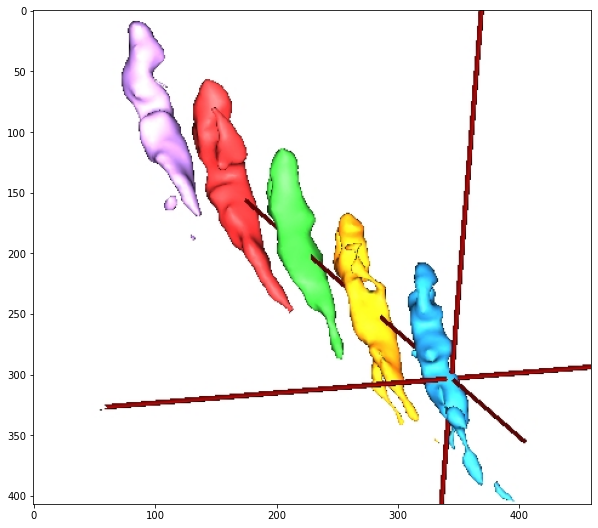

In [452]:
plt.figure(figsize=(10,10))
plt.imshow(ana.snapshot())

# Visualize individual clusters

In [436]:
n='5'
distances = pcpm.clusters.calc_distances_from_central(clusters[n], embedding)
central_name = pcpm.get_central_pc_name(embedding, clusters[n])
plus100 = {k:v-v.mean(axis=0) for k,v in clusters[n].items()}

In [437]:
ref = clusters[n][central_name]
aligned, _, _ = pcpm.align_pcs(plus100, ref, epsilon=0.001, max_iter=1000)

>>> INFO pcpm.transform - using 1 cores out of 4
Aligning point-clouds to reference: 100%|██████████| 20/20 [00:01<00:00, 11.17it/s]


In [438]:
mesh_params = dict(
    gblur_sigma=1,
    threshold=0.6,
    deciReductionRate=0,
    deciMaxError=1.0,
    deciMaxClearance=3.0,
    smoothRate=0.1,
    smoothIt=30
)
cluster_meshes = dtb.mesh_of_point_clouds(aligned, embedding=embedding, embedding_scale=5, **mesh_params)

rebuilding results: 100%|██████████| 20/20 [00:00<00:00, 26.06it/s]


In [439]:
ana.delete_all_objects()

In [440]:
shifted_meshes = {}
for name,mesh in cluster_meshes.items():
    shifted_meshes[name] = dtb.mesh.shift_aims_mesh_along_axis(mesh, offset=0, axis=1, scale=5)
    # shifted_meshes[name] = dtb.mesh.shift_aims_mesh_along_axis(mesh, offset=distances[name], axis=1, scale=5)

In [444]:
nb_samples = 10
samples = list(shifted_meshes.keys())
subsampling = np.random.choice(samples, size=nb_samples, replace=False)
subsampled_shifted_meshes = {key: shifted_meshes[key] for key in subsampling}

In [445]:
ana.clear()
ana(subsampled_shifted_meshes)
ana.set_objects_color(central_name, color="black")

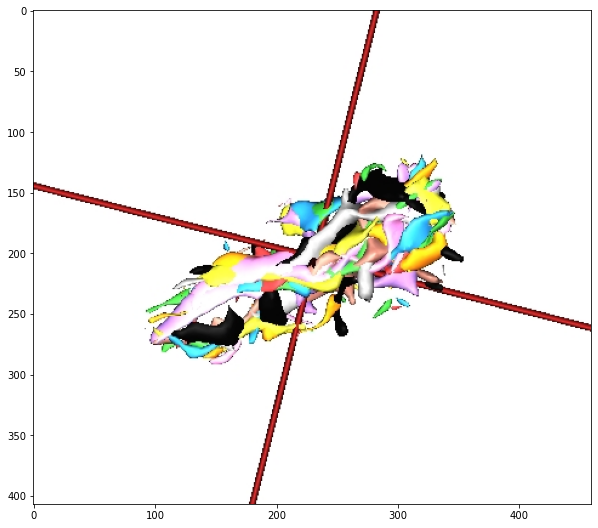

In [446]:
plt.figure(figsize=(10,10))
plt.imshow(ana.snapshot())